In [4]:
from residual_learning.utils import (
                BaseForecaster, 
                ResidualForecaster,
                TimeSeriesPreprocessor,
                crps,
                HistoricalForecaster
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape, rho_risk
import numpy as np
import time
from typing import Optional
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.models import (
                          BlockRNNModel, 
                          TCNModel, 
                          RNNModel, 
                          TransformerModel, 
                          NLinearModel,
                          DLinearModel,
                          NBEATSModel,
                          XGBModel,
                          LinearRegressionModel,
                          TFTModel,
                         )
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import CRPS.CRPS as forecastscore
from datetime import datetime, timedelta


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

In [5]:
data_preprocessor = TimeSeriesPreprocessor()
data_preprocessor.load()

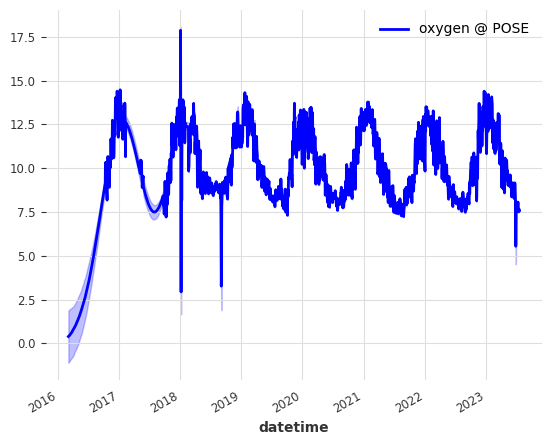

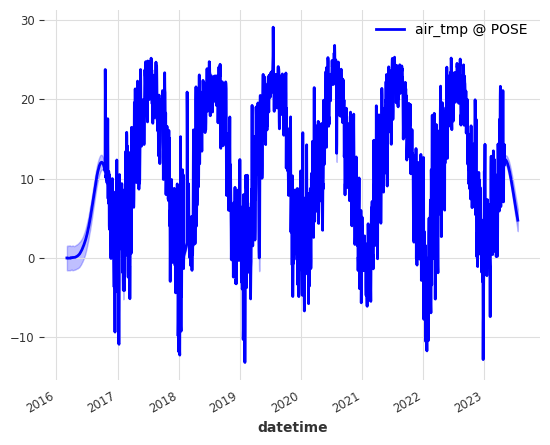

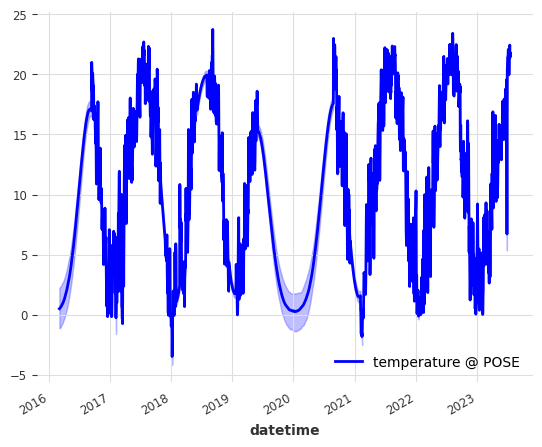

In [6]:
data_preprocessor.plot_by_site("POSE")

In [7]:
def make_plots(models, site, target_variable, data_preprocessor, tuned=False):
    # Loading the forecast csv and creating a time series
    for model_name in models:
        csv_name = f"forecasts/{site}/{target_variable}/{model_name}"
        if tuned:
            csv_name += "_tuned"
        df = pd.read_csv(f"{csv_name}.csv")
        times = pd.to_datetime(df["datetime"])
        times = pd.DatetimeIndex(times)
        values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
        model_forecast = TimeSeries.from_times_and_values(times, 
                                                          values, 
                                                          fill_missing_dates=True, freq="D")
        model_forecast.plot(label=f"{model_name}")

    # Presuming data_preprocessor has been called outside of the function
    # (not the best practice), create a validation series from it
    target_series = data_preprocessor.sites_dict[site][target_variable]
    validation_series = target_series.slice(times[0], times[-1]).median()

    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date=str(model_forecast.time_index[0])[:10],
                          forecast_horizon=len(model_forecast),
                          site_id=site,
                          target_variable=target_variable)
    historical_model.make_forecasts()
    
    validation_series.plot(label="Truth")
    historical_model.forecast_ts.plot(label="Historical")

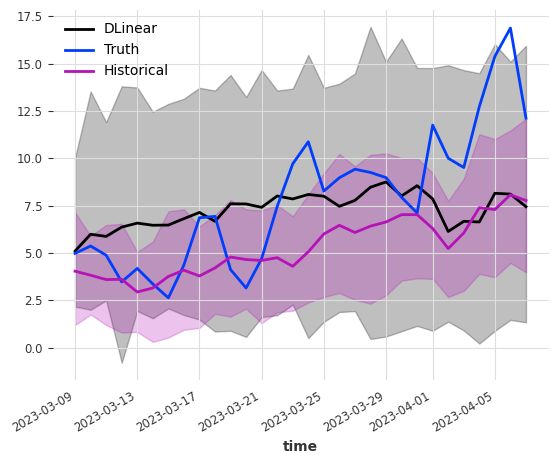

In [8]:
models = ["DLinear"]
make_plots(models, "POSE", "temperature", data_preprocessor)

In [19]:
import matplotlib as mpl
def make_crps_plots(models, site, target_variable, data_preprocessor, tuned=False):
    cmap = mpl.colormaps["tab20"]
    colors = cmap.colors
    # Loading the forecast csv and creating a time series
    for i, model_name in enumerate(models):
        csv_name = f"forecasts/{site}/{target_variable}/{model_name}"
        if tuned:
            csv_name += "_tuned"
        df = pd.read_csv(f"{csv_name}.csv")
        times = pd.to_datetime(df["datetime"])
        times = pd.DatetimeIndex(times)
        values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
        model_forecast = TimeSeries.from_times_and_values(times, 
                                                          values, 
                                                          fill_missing_dates=True, freq="D")

        if i == 0:
            # Presuming data_preprocessor has been called outside of the function
            # (not the best practice), create a validation series from it
            target_series = data_preprocessor.sites_dict[site][target_variable]
            validation_series = target_series.slice(times[0], times[-1])
            
        scores = crps(model_forecast, validation_series)
        scores.plot(label=f"{model_name}", color=colors[i])
        plt.axhline(y=scores.mean(axis=0).values()[0][0], linestyle='--',
                    color=colors[i])
            
    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date=str(model_forecast.time_index[0])[:10],
                          forecast_horizon=len(model_forecast),
                          site_id=site,
                          target_variable=target_variable)
    historical_model.make_forecasts()
    i += 1
    scores = crps(historical_model.forecast_ts, validation_series)
    scores.plot(label=f"Historical", color=colors[i])
    plt.axhline(y = scores.mean(axis=0).values()[0][0], linestyle = '--', color=colors[i])

In [20]:
def crps(forecast, observed):
    """
    Returns an array of CRPS scores 
    """
    forecast_array = forecast.pd_dataframe().values
    observed_array = observed.median().pd_series().values

    crps_scores = []
    for i in range(len(forecast_array)):
        # Note forecastscore is CRPS.CRPS
        crps, _, __ = forecastscore(forecast_array[i], observed_array[i]).compute()
        crps_scores.append(crps)

    crps_scores = TimeSeries.from_times_and_values(forecast.time_index, 
                                     crps_scores, 
                                     fill_missing_dates=True, freq="D")
    return crps_scores

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

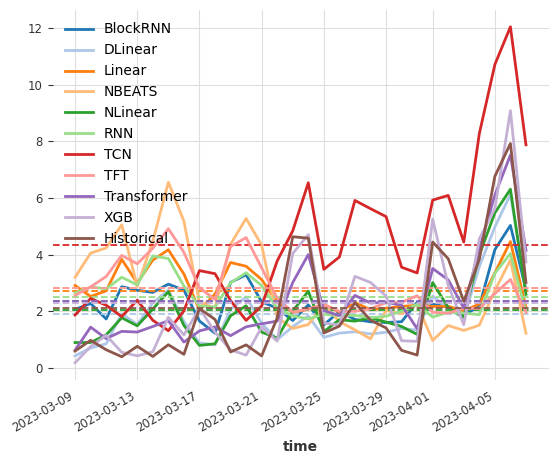

In [21]:
models = ["BlockRNN", "DLinear", "Linear", "NBEATS", "NLinear", "RNN",
          "TCN", "TFT", "Transformer", "XGB"]
make_crps_plots(models, "POSE", "temperature", data_preprocessor)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


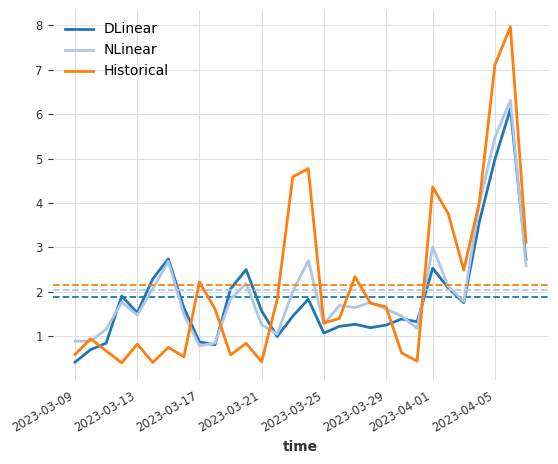

In [23]:
models = ["DLinear", "NLinear"]
make_crps_plots(models, "POSE", "temperature", data_preprocessor)